In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# OS: Conectar el data set

In [3]:
# Tomar el dataset
import os
current_dir = os.getcwd()
datasets_path = os.path.join(os.path.dirname(current_dir), "Datasets")
print(f"Datasets folder path: {datasets_path}")


Datasets folder path: c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\medicalHTR\Datasets


In [4]:
# Lista de nombres

import re
filenames = os.listdir(datasets_path) 
txt_pattern = r".+\.txt$"  # Matches any string followed by ".txt" at the end

# f[:-4] no incluye el ".txt", los ultimos 4 caracteres
files = [f[:-4] for f in filenames if re.match(txt_pattern, f)]

print(f"5 text files:")
for i in range(5):
    print(files[i])



5 text files:
24050201
24050202
24050203
24050204
24050205


# Usar una file

Tenemos
- `datasets_path`
- `files`

Se han de utilizar para buscar el archivo tipo imagen,
el cual en el caso de ser una versión recortada tendrá el mismo nombré pero con una "x" al final seguido de su extensión

In [5]:
def find_matching_file(datasets_path, files, pre_extension='x'):
    """
    Searches for a file in the specified directory that has the same name as a file in the
    provided list, but with an "x" appended before an unknown extension.
    Args:
        datasets_path: The absolute path to the directory containing the files.
        files: A list of filenames (without extensions) to search for.
    Returns:
        A list of matching filenames (including extensions) found in the directory,
        or an empty list if no matches are found.
    """

    matching_files = []

    if type(files) != list:
        files = [files] # little fix to get back list for 1-inputs too

    for filename in files:
        # Construct the matching pattern with a capture group for the extension
        pattern = (
            f"{filename}{pre_extension}\.([^\.]+)"  # Matches filename + 'x' + '.' + any characters
        )

        for entry in os.scandir(datasets_path):
            if entry.is_file() and re.match(pattern, entry.name):
                # Extract the extension from the matched filename
                extension = re.match(pattern, entry.name).group(1)
                matching_files.append(
                    f"{filename}{pre_extension}.{extension}"
                )  # Reconstruct full name with extension
                break  # Stop searching once a match is found for the current filename
    if matching_files:
        print("Matching files found:")
        for file in matching_files:
            print(file)
        return matching_files
    else:
        print("No matching files found.")
        return null
    

matching_files = find_matching_file(datasets_path, files)

Matching files found:
24050201x.jpeg
24050202x.jpeg
24050203x.jpeg
24050204x.jpeg
24050205x.jpeg
24050301x.png
24050302x.png
24050303x.png
24050304x.png
24050305x.png
24050306x.png
24050307x.png
24050308x.png
24050309x.png
24050310x.png


In [6]:
img_path = find_matching_file(datasets_path, files[0])[0]
img_path = os.path.join(datasets_path, img_path)
print(img_path)

Matching files found:
24050201x.jpeg
c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\medicalHTR\Datasets\24050201x.jpeg


Comenzando a utilizar las imagenes en cv2

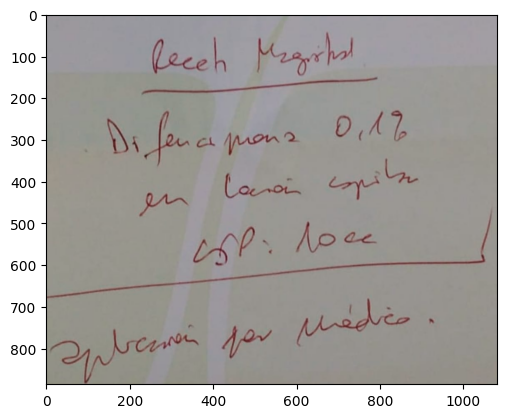

In [7]:
img = cv2.imread(img_path)
h,w,c = img.shape

plt.imshow(img)

## Counting Words from Label
By counting the number of spaces in the label, we can infer the number of words the model should be finding

In [8]:
matching_txt_files = find_matching_file(datasets_path, files[0], '')
label_path = matching_txt_files[0]
label_path = os.path.join(datasets_path, label_path)
print(label_path)

Matching files found:
24050201.txt
c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\medicalHTR\Datasets\24050201.txt


In [9]:
def count_text_stats(txt_path):
  """
  This function counts the number of characters (not blank spaces),
  words, and lines in a text file.

  Args:
      txt_path: The path to the text file.

  Returns:
      A dictionary containing the following keys:
          characters: The number of characters (not blank spaces).
          words: The number of words.
          lines: The number of lines.
  """

  # Initialize counters
  num_chars = 0
  num_words = 0
  num_lines = 0

  try:
    # Open the text file in read mode
    with open(txt_path, 'r') as f:
      for line in f:
        # Count lines
        num_lines += 1

        # Remove trailing newline character from the line
        line = line.rstrip()

        # Count characters (excluding spaces)
        num_chars += len(line.replace(" ", ""))

        # Count words (splitting by whitespace)
        num_words += len(line.split())

  except FileNotFoundError:
    print(f"Error: File not found at {txt_path}")

  # Return the counts as a dictionary
  return {"characters": num_chars, "words": num_words, "lines": num_lines}

# Example usage
stats = count_text_stats(label_path)

if stats:
  print(stats)


{'characters': 94, 'words': 13, 'lines': 6}


# Procesing as blobs

Thresholding es una tecnica utilizada para omitir amplitudes o activaciones muy bajas que consideramos en base a algun parametro. Utilizar 

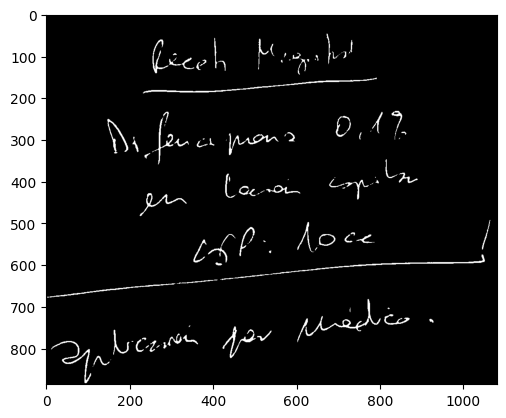

In [10]:
def thresholding(image, treshold=80):
    """Considera una mascara: img > treshold """
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray, treshold ,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(img, 95); #50, pi

- agregar transformada de Fourier FFt

In [11]:
thresh_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
# comparasión de la forma de los arreglos

img_fft = np.fft.rfft2(thresh_img)
print("shape tresh img:", thresh_img.shape)
print("shape ffttresh img:", img_fft.shape)

shape tresh img: (886, 1080)
shape ffttresh img: (886, 541)


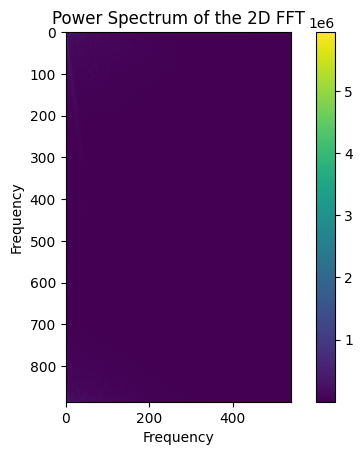

In [13]:
# Observando el espectro de la imagen, un espectro 2D

spectrum_log = np.log1p(
    np.abs(img_fft)
)

# plt.imshow(spectrum_log)
plt.imshow(np.abs(img_fft))
plt.colorbar()
plt.title('Power Spectrum of the 2D FFT')
plt.xlabel('Frequency')
plt.ylabel('Frequency')
plt.show()

## Tecnicas usadas:
- Transformada Rapida de Fourier
- Kernels (Filtros sobre imagen)
- Thresholding


Relaciones con otras tecnicas:
- adaptative sampling

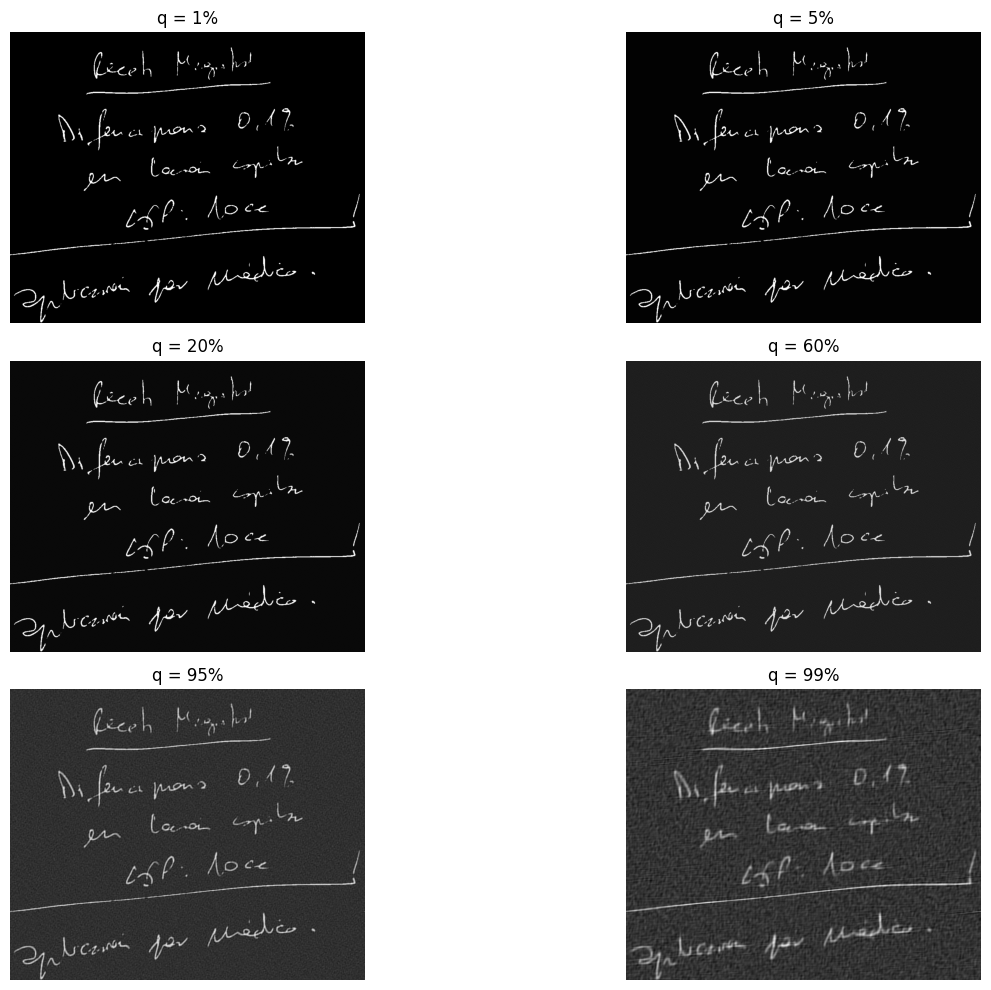

In [14]:
# percentil 5 porciento es bastante bueno, pero probemos otros
def fourier_cut(img_fft, q=5):
    """usa el percentil para filtrar en base a la magnitud absoluta"""
    mask= np.abs(img_fft) >= np.percentile(np.abs(img_fft), q=q)
    return img_fft * mask#img_fft_filterd 


# plt.imshow(np.fft.irfft2(img_fft_filterd))

q_values = [1, 5, 20, 60, 95, 99]
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()

# Loop over the q values and create a plot for each
for i, q in enumerate(q_values):
    img_fft_filtered = fourier_cut(img_fft, q=q)
    img_filtered = np.fft.irfft2(img_fft_filtered)  # Compute the inverse FFT and take the real part
    
    # Plot the filtered image
    axes[i].imshow(img_filtered, cmap='gray')
    axes[i].set_title(f'q = {q}%')
    axes[i].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Gaussian Kernels


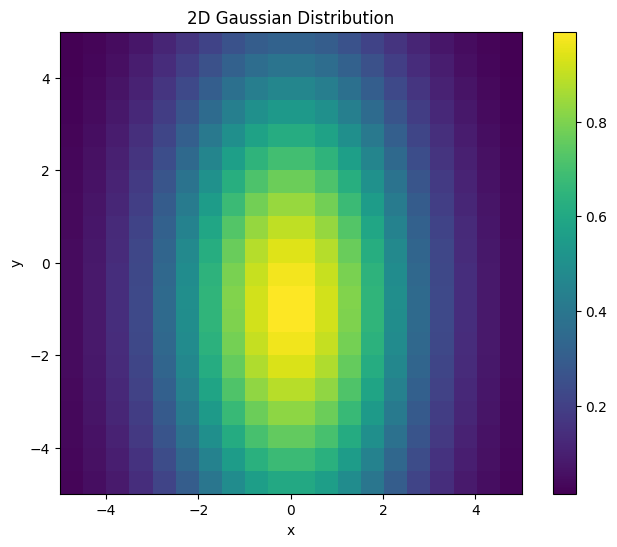

In [15]:
# Parameters for the Gaussian
mu_x, mu_y = 0, -1    # Means of the Gaussian in x and y
sigma_x, sigma_y = 2, 4  # Standard deviations of the Gaussian in x and y
amplitude = 1  # Amplitude of the Gaussian

# Create a grid of (x, y) coordinates
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
x, y = np.meshgrid(x, y)

# Compute the Gaussian function over the grid
gaussian = amplitude * np.exp(-0.5 * (((x - mu_x) / sigma_x)**2 + ((y - mu_y) / sigma_y)**2))

# Plot the Gaussian
plt.figure(figsize=(8, 6))
plt.imshow(gaussian, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('2D Gaussian Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



1. **Parameters for the Gaussian**:
   - `mu_x` and `mu_y` are the means of the Gaussian in the x and y directions, respectively.
   - `sigma_x` and `sigma_y` are the standard deviations of the Gaussian in the x and y directions, respectively.
   - `amplitude` is the peak value of the Gaussian.

2. **Create a grid of (x, y) coordinates**:
   - `x = np.linspace(-5, 5, 100)` and `y = np.linspace(-5, 5, 100)` create 1D arrays of x and y coordinates ranging from -5 to 5 with 100 points each.
   - `x, y = np.meshgrid(x, y)` creates a 2D grid of (x, y) coordinates.

3. **Compute the Gaussian function**:
   - The Gaussian function is computed over the grid using the formula for a 2D Gaussian distribution: 
     $$
     G(x, y) = A \exp\left(-0.5 \left(\left(\frac{x - \mu_x}{\sigma_x}\right)^2 + \left(\frac{y - \mu_y}{\sigma_y}\right)^2\right)\right)
     $$
   - This formula directly computes the Gaussian values over the grid.

4. **Plot the Gaussian**:
   - `plt.imshow` is used to display the 2D Gaussian distribution, with the color map set to 'viridis' and the color bar showing the amplitude values.

This approach leverages NumPy's vectorized operations to compute the Gaussian values in a concise manner.

In [16]:
# implement a gaussian kernel
gaussian.shape
gaussian.dtype

dtype('float64')

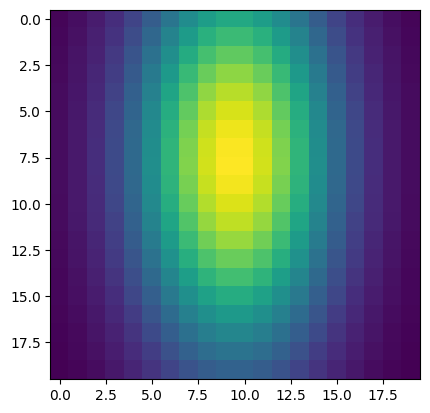

In [17]:
# Find the maximum value in the array
max_value = np.max(gaussian)

# Rescale the array values to the range [0, 1]
rescaled_gaussian = gaussian / max_value

# Scale the values to the range [0, 254]
rescaled_gaussian = rescaled_gaussian * 254

# Convert the array to np.uint8
rescaled_gaussian_uint8 = rescaled_gaussian.astype(np.uint8)
plt.imshow(rescaled_gaussian_uint8)

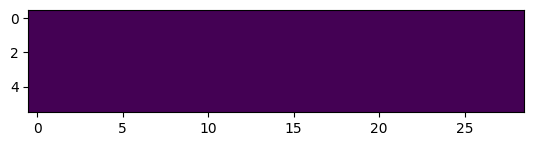

In [18]:
#dilation
kernel_dilation = np.ones((6,29), np.uint8)
plt.imshow(kernel_dilation)

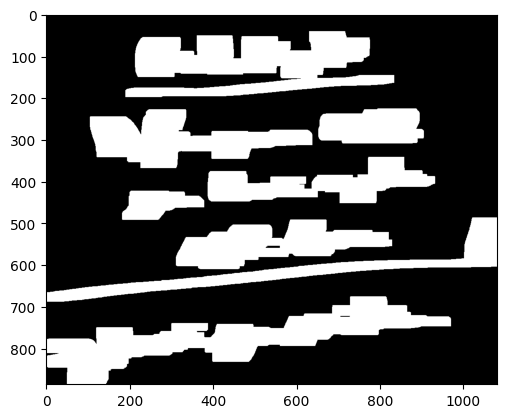

In [19]:

dilated = cv2.dilate(thresh_img, kernel_dilation, iterations = 3)
plt.imshow(dilated, cmap='gray');

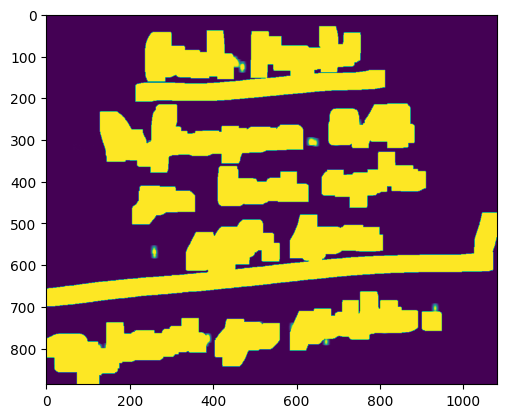

In [20]:
# gaussian kernel as comparison
rescaled_gaussian_uint8;

gaussianized_diy = thresh_img.copy()
num_iterations = 2

for _ in range(num_iterations):
    gaussianized_diy = cv2.filter2D(gaussianized_diy, -1, rescaled_gaussian_uint8)

plt.imshow(gaussianized_diy)

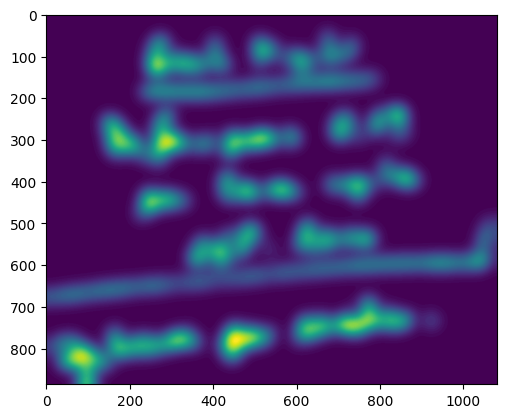

In [21]:
# filtros de CV2

ksize = (21, 21)  # Kernel size (must be an odd number)
sigmaX = 20  # Standard deviation in the X direction

# Apply Gaussian Blur

gaussianized = thresh_img.copy()
num_iterations = 10

for _ in range(num_iterations):
    gaussianized = cv2.GaussianBlur(gaussianized, ksize, sigmaX)


plt.imshow(gaussianized)

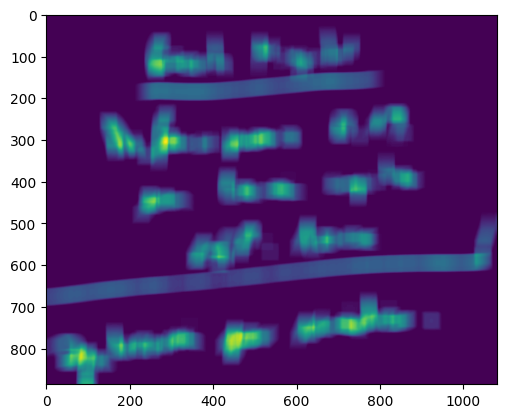

In [22]:
ksize1 = (3, 3)  # Kernel size (must be an odd number)
ksize2 = (41, 41)  # Kernel size (must be an odd number)
sigmaX = 40  # Standard deviation in the X direction

# Apply Gaussian Blur
gaussianized = cv2.GaussianBlur(thresh_img, ksize1, sigmaX)
gaussianized2 = cv2.GaussianBlur(gaussianized, ksize2, sigmaX)
plt.imshow(gaussianized2)

In [23]:
def contors(array):
    (contours, heirarchy) = cv2.findContours(array.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    return sorted_contours_lines

lines_dilated = contors(dilated)
lines_gaussianized_diy = contors(gaussianized_diy)
gaussianized2_gaussianized2 = contors(gaussianized2)

# Line Segment

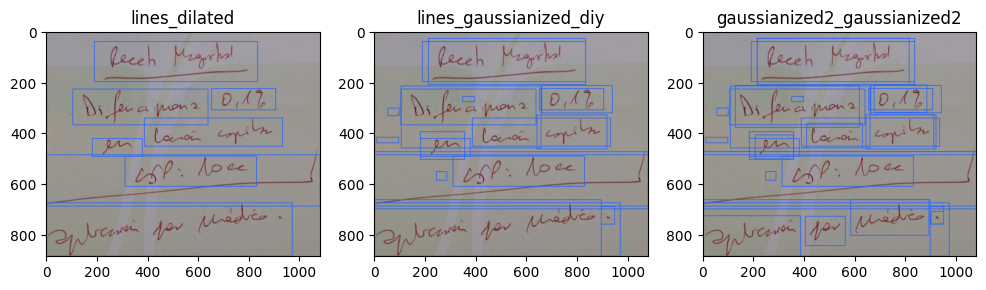

In [27]:
img2 = img.copy()

test_contors = [lines_dilated, lines_gaussianized_diy, gaussianized2_gaussianized2]
titles = ["lines_dilated", "lines_gaussianized_diy", "gaussianized2_gaussianized2"]
fig, ax = plt.subplots(1,3, figsize=(12,8))

w_arr = []
h_arr = []


for idx, sorted_contours_lines in enumerate(test_contors):
    for ctr in sorted_contours_lines:
        x,y,w,h = cv2.boundingRect(ctr)
        w_arr.append(w)
        h_arr.append(h)
        if w>=20 and h>=20:
            cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)
        
    ax[idx].imshow(img2)
    ax[idx].set_title(titles[idx])

plt.show()

In [35]:
w_arr = np.array(w_arr)
h_arr = np.array(h_arr)

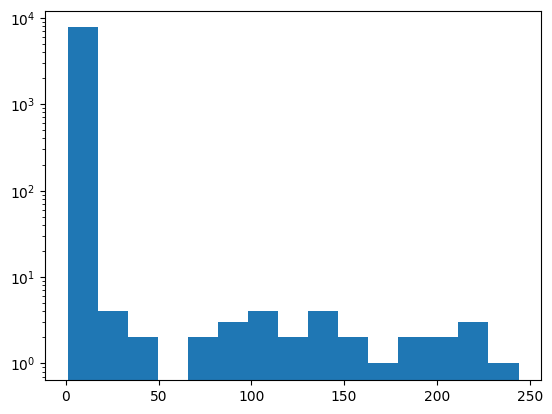

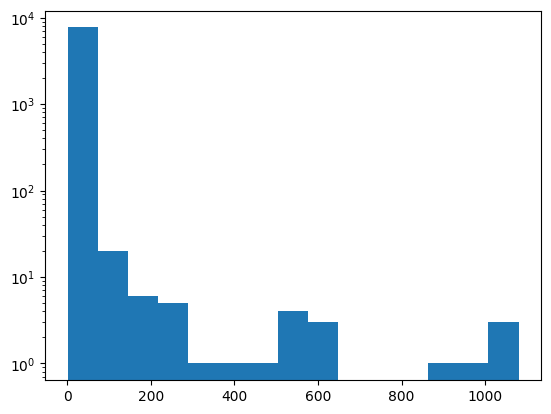

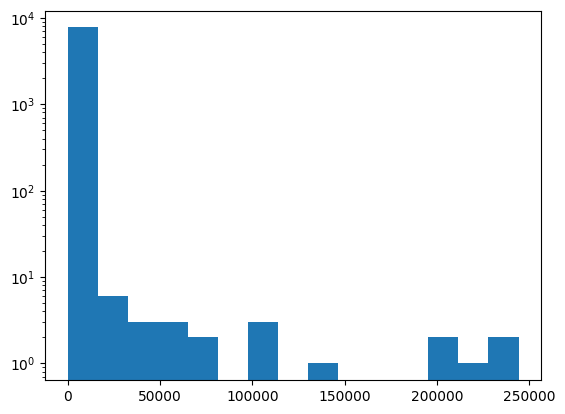

In [37]:
plt.hist(h_arr, bins=15)
plt.yscale('log')
plt.show()

plt.hist(w_arr, bins=15)
plt.yscale('log')
plt.show()

plt.hist(w_arr*h_arr, bins=15)
plt.yscale('log')
plt.show()



In [25]:

# usando un kernel dilation al final de cada filtro nuevamente
ddilated = cv2.GaussianBlur(dilated, ksize, sigmaX)
dgaussianized_diy = cv2.dilate(dilated, kernel_dilation, iterations = n_iter)
dgaussianized2 = cv2.dilate(dilated, kernel_dilation, iterations = n_iter)

lines_dilated = contors(ddilated)
lines_gaussianized_diy = contors(dgaussianized_diy)
gaussianized2_gaussianized2 = contors(dgaussianized2)

test_contors = [lines_dilated, lines_gaussianized_diy, gaussianized2_gaussianized2]
titles = ["lines_dilated", "lines_gaussianized_diy", "gaussianized2_gaussianized2"]
fig, ax = plt.subplots(1,3, figsize=(12,8))

for idx, sorted_contours_lines in enumerate(test_contors):
    for ctr in sorted_contours_lines:
        x,y,w,h = cv2.boundingRect(ctr)
        cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)
        
    ax[idx].imshow(img2)
    ax[idx].set_title(titles[idx])

plt.show()

# los resultados empeoran, para ello es importante entender el funcionamiento del bounding box
# como determina aquellos puntos?

NameError: name 'n_iter' is not defined

# Text Segment

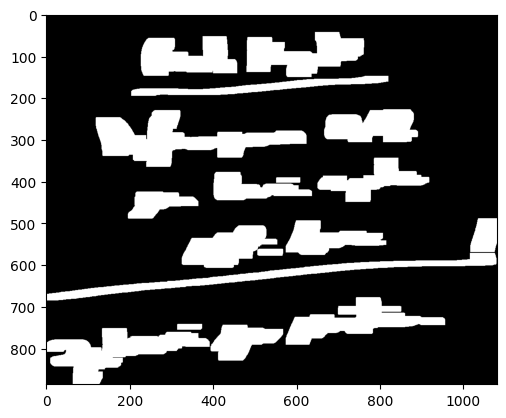

In [ ]:
#dilation
kernel = np.ones((6,29), np.uint8)
dilated2 = cv2.dilate(thresh_img, kernel, iterations = 2)
plt.imshow(dilated2, cmap='gray');

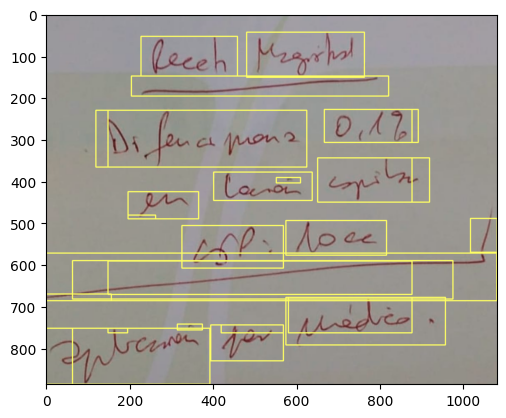

In [ ]:
img3 = img.copy()
words_list = []

for line in sorted_contours_lines:
    
    # roi of each line
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y+w, x:x+w]
    
    # draw contours on each word
    (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])
    
    for word in sorted_contour_words:
        
        if cv2.contourArea(word) < 400:
            continue
        
        x2, y2, w2, h2 = cv2.boundingRect(word)
        words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
        cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (255,255,100),2)
        
plt.imshow(img3);

In [ ]:
len(sorted_contours_lines)

4

In [ ]:
# for i in range(len(words_list)):
#     ninth_word = words_list[i]
#     roi_9 = img[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
#     plt.imshow(roi_9)
#    plt.show()

